In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
# from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
# import cv2
import os
from PIL import Image
from torch.utils.data import Dataset, random_split
from tqdm import tqdm
from sklearn import metrics
import seaborn as sns
import numpy as np

import torch.nn.functional as F
import torchvision.transforms.v2 as T

import albumentations as A
import albumentations.augmentations.functional as A_F
import albumentations.pytorch as A_P

In [2]:
# import torch
# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
#     in_channels=3, out_channels=1, init_features=32, pretrained=True)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
def double_conv(in_channels, out_channels, num_groups=8):

    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        # nn.GroupNorm(num_groups=min(out_channels, num_groups), num_channels=out_channels),
        nn.BatchNorm2d(out_channels),
        # nn.ReLU(inplace=True),
        nn.LeakyReLU(0.1, inplace=True),
        
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        # nn.GroupNorm(num_groups=min(out_channels, num_groups), num_channels=out_channels),
        nn.BatchNorm2d(out_channels),
        # nn.ReLU(inplace=True)
        nn.LeakyReLU(0.1, inplace=True)
    )

class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)  
        self.dconv_down5 = double_conv(512, 1024)  

        self.maxpool = nn.MaxPool2d(2)
        
        self.dconv_up4 = double_conv(1024, 512)
        self.dconv_up3 = double_conv(512, 256)
        self.dconv_up2 = double_conv(256, 128)
        self.dconv_up1 = double_conv(128, 64)

        
        self.TConv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.TConv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.TConv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.TConv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, x):
        # ENCODER
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        
        # x = self.dconv_down4(x)

        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4)

        # BOTTLENECK
        x = self.dconv_down5(x)

        # DECODER
        x = self.TConv4(x)
        x = torch.cat([x, conv4], dim=1)
        x = self.dconv_up4(x)
        
        x = self.TConv3(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        
        x = self.TConv2(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)
        
        x = self.TConv1(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        # out = F.sigmoid(out)
        
        return out

In [5]:
model = UNet(1)
demo_data = torch.rand(16, 1, 128, 128)

print(demo_data.size())
demo_output = model(demo_data)

print(demo_output.size())

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


## load data

In [6]:
train_transforms = A.Compose([
    A.RandomRotate90(),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    # A.RandomRotate90(),
    A.RandomResizedCrop(height=128, width=128),
    A.Normalize(mean=(0.5), std=(0.5)),  # For grayscale images
    A_P.ToTensorV2(),  # Convert to PyTorch tensor
])

val_transforms = A.Compose([
    A.RandomResizedCrop(height=128, width=128),
    A.Normalize(mean=(0.5,), std=(0.5,)),  # For grayscale images
    A_P.ToTensorV2(),  # Convert to PyTorch tensor
])

In [7]:
# Define your custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # Assuming that image and mask file names are aligned (e.g., image_001.png -> mask_001.png)
        self.image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith('.png') or f.endswith('.jpg')])
        self.mask_filenames = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png') or f.endswith('.jpg')])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Load image and corresponding mask
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        image = np.array(image)
        mask = np.array(mask)

        if self.transform:
            # Apply transformations
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image'].float()
            # mask = augmented['mask'][np.newaxis, :, :].float()
            mask = (augmented["mask"] / 255).float().unsqueeze(0)

        # print(min(image.view(-1)))
        # print(max(image.view(-1)))
        # print(min(mask.view(-1)))
        # print(max(mask.view(-1)))
        
        return image, mask

In [8]:
# Split the dataset into training, validation, and test sets (80% train, 10% validation, 10% test)
# train_size = int(0.8 * len(dataset))
# valid_size = int(0.1 * len(dataset))
# test_size = len(dataset) - train_size - valid_size

# train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])
# train_transforms = ConsistentTransform(get_transforms())

train_dataset = CustomDataset(
    image_dir="dataset-covid19-ct-scans/train/images/", 
    mask_dir="dataset-covid19-ct-scans/train/labels/", 
    transform=train_transforms)

valid_dataset = CustomDataset(
    image_dir="dataset-covid19-ct-scans/val/images/", 
    mask_dir="dataset-covid19-ct-scans/val/labels/", 
    transform=val_transforms)

test_dataset = CustomDataset(
    image_dir="dataset-covid19-ct-scans/test/images/", 
    mask_dir="dataset-covid19-ct-scans/test/labels/", 
    transform=val_transforms)

# Create DataLoader for each subset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True,  drop_last=True)

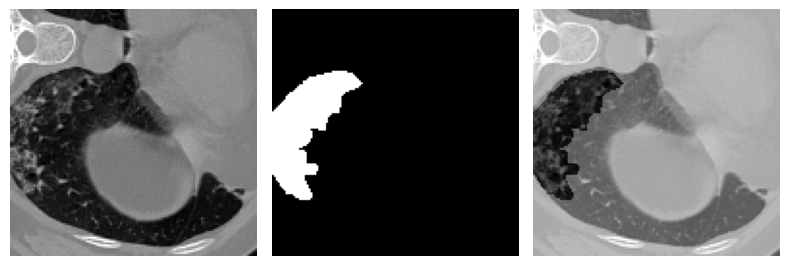

In [9]:
fig, axes = plt.subplots(1,3, figsize=(8,5))

image, mask = train_dataset[100]

axes[0].imshow(image.permute(1,2,0), cmap="grey")
axes[0].axis("off")
axes[1].imshow(mask.permute(1,2,0), cmap="grey")
axes[1].axis("off")
axes[2].imshow((image-mask).permute(1,2,0), cmap="grey")
axes[2].axis("off")

plt.tight_layout()
plt.show()

# Training

### *Loss Function*

In [10]:
class WeightedBCELoss(nn.Module):
    def __init__(self, weight=[1.5, 1.]):
        super(WeightedBCELoss, self).__init__()
        self.weight = torch.Tensor(weight)
        self.bce_with_logits = nn.BCEWithLogitsLoss(reduction='none')
    
    def forward(self, logits, targets):
        # Apply sigmoid to logits to get probabilities
        # probs = torch.sigmoid(logits)
        loss = self.bce_with_logits(logits, targets)
        
        # Compute the weighted BCE loss
        # loss = -(self.weight[1] * targets * torch.log(probs + 1e-12) +
                  # self.weight[0] * (1 - targets) * torch.log(1 - probs + 1e-12))
        weighted_loss = self.weight[1] * targets * loss + self.weight[0] * (1 - targets) * loss
        
        return weighted_loss.mean()

In [11]:
def compute_iou(predictions, targets, threshold=0.5):

    # Convert probabilities to binary masks
    preds = (predictions > threshold).float()
    targets = targets.float()

    # Calculate intersection and union
    intersection = (preds * targets).sum()

    union = preds.sum() + targets.sum() - intersection

    # Avoid division by zero
    if union == 0:
        return 1.0

    iou = intersection / union
    return iou.item()

In [12]:
def dice_loss(inputs, targets):
    """Calculate Dice Loss"""
    smooth=1e-6
    inputs = torch.sigmoid(inputs)  # Apply sigmoid to get probabilities
    intersection = (inputs * targets).sum()
    dice_coeff = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
    return 1 - dice_coeff  # Return the Dice Loss

In [13]:
def combined_loss(preds, targets, alpha=0.5):
    bce_loss = criterion(preds, targets)
    dice_loss_value = dice_loss(preds, targets)
    return alpha * bce_loss + (1 - alpha) * dice_loss_value

### *Train model*

In [14]:
# U-Net model
model = model.to(device)
# model = nn.DataParallel(model)

# Loss and Optimizer
# criterion = WeightedBCELoss()  # Binary Cross-Entropy Loss
pos_weight = torch.tensor([0.6]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Training Loop
# num_epochs = 20
# best_valid_loss = float('inf')

In [15]:
# # Function to calculate accuracy (optional but useful for monitoring performance)
# def calc_accuracy(pred, target):
#     pred = torch.sigmoid(pred)
#     pred = (pred > 0.5).float()  # Binary segmentation: threshold at 0.5
#     correct = (pred == target).float()
#     acc = correct.sum() / torch.numel(correct)
#     return acc

# Training function
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=20, early_stopping_patience=20):
    best_loss = float('inf')
    patience_counter = 0  # Counter to keep track of patience

    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        
        for images, masks in tqdm(train_loader):
            images, masks = images.to(device), masks.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Compute loss
            loss = criterion(outputs, masks)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Accumulate the loss and accuracy
            train_loss += loss.item()
            train_acc += compute_iou(outputs, masks)
        
        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = train_acc / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accs.append(avg_train_acc)
        
        # Validation phase
        model.eval()
        valid_loss = 0.0
        valid_acc = 0.0
        
        with torch.no_grad():
            for images, masks in tqdm(valid_loader):
                images, masks = images.to(device), masks.to(device)
                
                # Forward pass
                outputs = model(images)
                
                # Compute loss
                loss = criterion(outputs, masks)
                
                # Accumulate the loss and accuracy
                valid_loss += loss.item()
                valid_acc += compute_iou(outputs, masks)
        
        avg_valid_loss = valid_loss / len(valid_loader)
        avg_valid_acc = valid_acc / len(valid_loader)
        valid_losses.append(avg_valid_loss)
        valid_accs.append(avg_valid_acc)
        
        print(f'loss: {avg_train_loss} - iou: {avg_train_acc} - val_loss: {avg_valid_loss} - val_iou: {avg_valid_acc}')
        
        # Save the model if the validation loss improves
        if avg_valid_loss < best_loss:
            print(f'Validation loss decreased ({best_loss} --> {avg_valid_loss}). Saving model...')
            torch.save(model.state_dict(), 'best_model.pth')
            best_loss = avg_valid_loss
            patience_counter = 0
        else:
            patience_counter += 1
            print(f'No improvement in validation loss. Patience counter: {patience_counter}/{early_stopping_patience}')

        # Early stopping condition
        if patience_counter >= early_stopping_patience:
            print('Early stopping triggered. Stopping training...')
            break
    
    print('Training complete.')
    return {
        "train_losses": train_losses,
        "valid_losses": valid_losses,
        "train_iou": train_accs,
        "valid_iou": valid_accs
    }

# Start the training process
history = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=150)

Epoch 1/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.50it/s]


loss: 0.4115885031504894 - iou: 0.008415380764136634 - val_loss: 0.3526898779367146 - val_iou: 0.22250768802079715
Validation loss decreased (inf --> 0.3526898779367146). Saving model...
Epoch 2/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.30it/s]


loss: 0.29278258826788955 - iou: 0.34885542059507896 - val_loss: 0.28398531518484416 - val_iou: 0.2796885418264489
Validation loss decreased (0.3526898779367146 --> 0.28398531518484416). Saving model...
Epoch 3/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.53it/s]


loss: 0.24230993697493095 - iou: 0.43890548224641585 - val_loss: 0.22787302654040487 - val_iou: 0.4198051659684432
Validation loss decreased (0.28398531518484416 --> 0.22787302654040487). Saving model...
Epoch 4/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.57it/s]


loss: 0.19677907345801826 - iou: 0.44921723682814696 - val_loss: 0.1864730041278036 - val_iou: 0.4021101813567312
Validation loss decreased (0.22787302654040487 --> 0.1864730041278036). Saving model...
Epoch 5/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.41it/s]


loss: 0.16281711574145188 - iou: 0.4457745233653333 - val_loss: 0.16010763613801254 - val_iou: 0.4217567494825313
Validation loss decreased (0.1864730041278036 --> 0.16010763613801254). Saving model...
Epoch 6/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.12it/s]


loss: 0.13531172469140976 - iou: 0.4979985316437999 - val_loss: 0.1374421205959822 - val_iou: 0.4578423487316621
Validation loss decreased (0.16010763613801254 --> 0.1374421205959822). Saving model...
Epoch 7/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.12it/s]


loss: 0.11296041655962862 - iou: 0.4972243652803691 - val_loss: 0.11387822580964942 - val_iou: 0.47684722151117104
Validation loss decreased (0.1374421205959822 --> 0.11387822580964942). Saving model...
Epoch 8/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.90it/s]


loss: 0.09527303659775126 - iou: 0.507844207089717 - val_loss: 0.09419514474115874 - val_iou: 0.4335326493570679
Validation loss decreased (0.11387822580964942 --> 0.09419514474115874). Saving model...
Epoch 9/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.07it/s]


loss: 0.08122939575375535 - iou: 0.5407972308829074 - val_loss: 0.09306291647647556 - val_iou: 0.4376242415685403
Validation loss decreased (0.09419514474115874 --> 0.09306291647647556). Saving model...
Epoch 10/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.10it/s]


loss: 0.06972907683042091 - iou: 0.5351076209404337 - val_loss: 0.0779737712521302 - val_iou: 0.3401003981891431
Validation loss decreased (0.09306291647647556 --> 0.0779737712521302). Saving model...
Epoch 11/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.22it/s]


loss: 0.06020085733589225 - iou: 0.5551265447627841 - val_loss: 0.06577952617877408 - val_iou: 0.4878263755848533
Validation loss decreased (0.0779737712521302 --> 0.06577952617877408). Saving model...
Epoch 12/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.95it/s]


loss: 0.053730781652092 - iou: 0.5417288838643727 - val_loss: 0.06291103892420467 - val_iou: 0.42434108492575195
Validation loss decreased (0.06577952617877408 --> 0.06291103892420467). Saving model...
Epoch 13/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.77it/s]


loss: 0.04746456162666711 - iou: 0.5305140456698072 - val_loss: 0.04868698806354874 - val_iou: 0.5519357178556291
Validation loss decreased (0.06291103892420467 --> 0.04868698806354874). Saving model...
Epoch 14/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.15it/s]


loss: 0.04229041658283219 - iou: 0.5430807114586117 - val_loss: 0.051831185621650594 - val_iou: 0.41604271452677877
No improvement in validation loss. Patience counter: 1/20
Epoch 15/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.08it/s]


loss: 0.03714660691522707 - iou: 0.5776516074740042 - val_loss: 0.059013169749002704 - val_iou: 0.424441197985097
No improvement in validation loss. Patience counter: 2/20
Epoch 16/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.05it/s]


loss: 0.033436478885609335 - iou: 0.5834630687875072 - val_loss: 0.06379738783365801 - val_iou: 0.4212877421002639
No improvement in validation loss. Patience counter: 3/20
Epoch 17/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.00it/s]


loss: 0.030341543917228857 - iou: 0.5852326098389513 - val_loss: 0.04274057959647555 - val_iou: 0.529987140705711
Validation loss decreased (0.04868698806354874 --> 0.04274057959647555). Saving model...
Epoch 18/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.78it/s]


loss: 0.027728671897349396 - iou: 0.5939855928730777 - val_loss: 0.04404527684183497 - val_iou: 0.49518379098490667
No improvement in validation loss. Patience counter: 1/20
Epoch 19/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.84it/s]


loss: 0.025710213401420847 - iou: 0.5966503581428152 - val_loss: 0.05096053116415676 - val_iou: 0.43570437243110255
No improvement in validation loss. Patience counter: 2/20
Epoch 20/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.19it/s]


loss: 0.023800471958916956 - iou: 0.5998865600646012 - val_loss: 0.04049947000059642 - val_iou: 0.48528945132305745
Validation loss decreased (0.04274057959647555 --> 0.04049947000059642). Saving model...
Epoch 21/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.34it/s]


loss: 0.02169379649141173 - iou: 0.6049979059245643 - val_loss: 0.03271486918981138 - val_iou: 0.5407271851834498
Validation loss decreased (0.04049947000059642 --> 0.03271486918981138). Saving model...
Epoch 22/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.16it/s]


loss: 0.02019620859100828 - iou: 0.59427843647679 - val_loss: 0.027170550421272453 - val_iou: 0.5347673414569152
Validation loss decreased (0.03271486918981138 --> 0.027170550421272453). Saving model...
Epoch 23/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.40it/s]


loss: 0.019775213461046614 - iou: 0.5588617038539075 - val_loss: 0.03168670269415567 - val_iou: 0.49538716360142354
No improvement in validation loss. Patience counter: 1/20
Epoch 24/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.39it/s]


loss: 0.018687019307958328 - iou: 0.5885379739164367 - val_loss: 0.032197235446227226 - val_iou: 0.409234134774459
No improvement in validation loss. Patience counter: 2/20
Epoch 25/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.28it/s]


loss: 0.01680698099832131 - iou: 0.6080316572677432 - val_loss: 0.025807237154559085 - val_iou: 0.5645977995897594
Validation loss decreased (0.027170550421272453 --> 0.025807237154559085). Saving model...
Epoch 26/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.11it/s]


loss: 0.015680100996135257 - iou: 0.5972822945652985 - val_loss: 0.03861814950543799 - val_iou: 0.44242102378293086
No improvement in validation loss. Patience counter: 1/20
Epoch 27/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.29it/s]


loss: 0.015038055859095468 - iou: 0.6024463730534231 - val_loss: 0.03614804604531903 - val_iou: 0.5273373221096239
No improvement in validation loss. Patience counter: 2/20
Epoch 28/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


loss: 0.014099035639403842 - iou: 0.6020341470954925 - val_loss: 0.024511389875490414 - val_iou: 0.49916325666402517
Validation loss decreased (0.025807237154559085 --> 0.024511389875490414). Saving model...
Epoch 29/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.26it/s]


loss: 0.013828656042185356 - iou: 0.6017089132366218 - val_loss: 0.038298189100858415 - val_iou: 0.45286708991778524
No improvement in validation loss. Patience counter: 1/20
Epoch 30/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.00it/s]


loss: 0.014371892547337558 - iou: 0.5490918910409522 - val_loss: 0.023938669357448816 - val_iou: 0.49057140593466003
Validation loss decreased (0.024511389875490414 --> 0.023938669357448816). Saving model...
Epoch 31/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.33it/s]


loss: 0.01235339025724826 - iou: 0.5999103568083658 - val_loss: 0.0285412725551348 - val_iou: 0.5142053867641249
No improvement in validation loss. Patience counter: 1/20
Epoch 32/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.84it/s]


loss: 0.012653194074555644 - iou: 0.5892761584341996 - val_loss: 0.026142997544650968 - val_iou: 0.4934006568632628
No improvement in validation loss. Patience counter: 2/20
Epoch 33/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.20it/s]


loss: 0.011614549428400562 - iou: 0.6089583882900673 - val_loss: 0.02739936244477959 - val_iou: 0.5274387974488107
No improvement in validation loss. Patience counter: 3/20
Epoch 34/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.43it/s]


loss: 0.011693624559584566 - iou: 0.6014457693484825 - val_loss: 0.033798596012945235 - val_iou: 0.5268003344535828
No improvement in validation loss. Patience counter: 4/20
Epoch 35/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.97it/s]


loss: 0.01064868001120649 - iou: 0.6258370444530578 - val_loss: 0.028775243333687906 - val_iou: 0.5074119316904169
No improvement in validation loss. Patience counter: 5/20
Epoch 36/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.04it/s]


loss: 0.011025541770000627 - iou: 0.6028002059365821 - val_loss: 0.03497329334679403 - val_iou: 0.442150941020564
No improvement in validation loss. Patience counter: 6/20
Epoch 37/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.07it/s]


loss: 0.010760226818608252 - iou: 0.585983985521662 - val_loss: 0.0487251540547923 - val_iou: 0.43235521724349574
No improvement in validation loss. Patience counter: 7/20
Epoch 38/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.78it/s]


loss: 0.01049105637142156 - iou: 0.6027831187633079 - val_loss: 0.040943675000514636 - val_iou: 0.5012099570349643
No improvement in validation loss. Patience counter: 8/20
Epoch 39/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.70it/s]


loss: 0.010035057878488397 - iou: 0.6172108740553143 - val_loss: 0.03372442319155916 - val_iou: 0.5223915090686396
No improvement in validation loss. Patience counter: 9/20
Epoch 40/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.36it/s]


loss: 0.010153862702711595 - iou: 0.6005761484930835 - val_loss: 0.025249975586408062 - val_iou: 0.5379303089882198
No improvement in validation loss. Patience counter: 10/20
Epoch 41/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.24it/s]


loss: 0.009458748143400968 - iou: 0.6186465116467063 - val_loss: 0.03099536388426235 - val_iou: 0.5203359346640738
No improvement in validation loss. Patience counter: 11/20
Epoch 42/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.76it/s]


loss: 0.008750129986085056 - iou: 0.641858745043672 - val_loss: 0.04055052697903624 - val_iou: 0.4586313508058849
No improvement in validation loss. Patience counter: 12/20
Epoch 43/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.38it/s]


loss: 0.008775622382261388 - iou: 0.6380484193328797 - val_loss: 0.02124113074846958 - val_iou: 0.5755934699585563
Validation loss decreased (0.023938669357448816 --> 0.02124113074846958). Saving model...
Epoch 44/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.16it/s]


loss: 0.009642656274711874 - iou: 0.6013272641681311 - val_loss: 0.022665623152677557 - val_iou: 0.5461121946573257
No improvement in validation loss. Patience counter: 1/20
Epoch 45/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.06it/s]


loss: 0.00909848152439836 - iou: 0.6214200736969475 - val_loss: 0.018909537227285143 - val_iou: 0.5817740528207076
Validation loss decreased (0.02124113074846958 --> 0.018909537227285143). Saving model...
Epoch 46/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.96it/s]


loss: 0.008637767767269664 - iou: 0.6202756742558141 - val_loss: 0.02783485873308229 - val_iou: 0.47913406789302826
No improvement in validation loss. Patience counter: 1/20
Epoch 47/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.33it/s]


loss: 0.008334891140959628 - iou: 0.6256187210871479 - val_loss: 0.024068950785716112 - val_iou: 0.5290959069603368
No improvement in validation loss. Patience counter: 2/20
Epoch 48/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.91it/s]


loss: 0.00813428994715507 - iou: 0.6327706962589204 - val_loss: 0.029737407905294708 - val_iou: 0.539328335147155
No improvement in validation loss. Patience counter: 3/20
Epoch 49/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.20it/s]


loss: 0.008399708469684316 - iou: 0.6266903383290674 - val_loss: 0.022674331833657465 - val_iou: 0.5312971378627577
No improvement in validation loss. Patience counter: 4/20
Epoch 50/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 10.54it/s]


loss: 0.007927238640529433 - iou: 0.633684924737675 - val_loss: 0.022421199160529988 - val_iou: 0.4743549666906658
No improvement in validation loss. Patience counter: 5/20
Epoch 51/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.23it/s]


loss: 0.007848163370013707 - iou: 0.6202645955357965 - val_loss: 0.01808411867578367 - val_iou: 0.583436939473215
Validation loss decreased (0.018909537227285143 --> 0.01808411867578367). Saving model...
Epoch 52/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.20it/s]


loss: 0.007700273910112034 - iou: 0.6221395906970257 - val_loss: 0.04228648007847369 - val_iou: 0.44184717849681254
No improvement in validation loss. Patience counter: 1/20
Epoch 53/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.11it/s]


loss: 0.007999685580116205 - iou: 0.6309366798776341 - val_loss: 0.017049902235157788 - val_iou: 0.6086152062604302
Validation loss decreased (0.01808411867578367 --> 0.017049902235157788). Saving model...
Epoch 54/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.32it/s]


loss: 0.007700698624372365 - iou: 0.6360317912158064 - val_loss: 0.01744960906829587 - val_iou: 0.6191243309723703
No improvement in validation loss. Patience counter: 1/20
Epoch 55/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.91it/s]


loss: 0.007190938580663889 - iou: 0.6428632970870011 - val_loss: 0.028870031139568278 - val_iou: 0.5378906083734412
No improvement in validation loss. Patience counter: 2/20
Epoch 56/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.40it/s]


loss: 0.007772256986890722 - iou: 0.63450228323148 - val_loss: 0.02166742566164191 - val_iou: 0.486887022068626
No improvement in validation loss. Patience counter: 3/20
Epoch 57/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.41it/s]


loss: 0.007641231591215607 - iou: 0.6366272885499038 - val_loss: 0.024526928526986586 - val_iou: 0.5570314840266579
No improvement in validation loss. Patience counter: 4/20
Epoch 58/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.09it/s]


loss: 0.007860534373436152 - iou: 0.6188486293544919 - val_loss: 0.02354122970351263 - val_iou: 0.5066129831891311
No improvement in validation loss. Patience counter: 5/20
Epoch 59/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


loss: 0.007469178182916261 - iou: 0.6247183828372654 - val_loss: 0.034792903973108254 - val_iou: 0.47434166544362116
No improvement in validation loss. Patience counter: 6/20
Epoch 60/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.25it/s]


loss: 0.007484477741174458 - iou: 0.637515743651728 - val_loss: 0.01945803278910094 - val_iou: 0.4600073261872718
No improvement in validation loss. Patience counter: 7/20
Epoch 61/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.87it/s]


loss: 0.0067538960844161005 - iou: 0.6590804955152076 - val_loss: 0.03663702716125714 - val_iou: 0.4755291954467171
No improvement in validation loss. Patience counter: 8/20
Epoch 62/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.30it/s]


loss: 0.006909509344341776 - iou: 0.6301595721188493 - val_loss: 0.023038197445107232 - val_iou: 0.574985218675513
No improvement in validation loss. Patience counter: 9/20
Epoch 63/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.40it/s]


loss: 0.007372246476762935 - iou: 0.6370518387067975 - val_loss: 0.01827255765582729 - val_iou: 0.662868669158534
No improvement in validation loss. Patience counter: 10/20
Epoch 64/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.29it/s]


loss: 0.007106782415676422 - iou: 0.6253510255982556 - val_loss: 0.026875346545191286 - val_iou: 0.6127280741930008
No improvement in validation loss. Patience counter: 11/20
Epoch 65/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.43it/s]


loss: 0.0071267451610650834 - iou: 0.6397365080559347 - val_loss: 0.024248771819800726 - val_iou: 0.5380240208224246
No improvement in validation loss. Patience counter: 12/20
Epoch 66/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.27it/s]


loss: 0.006675621427734947 - iou: 0.6492770156991763 - val_loss: 0.021340208607541985 - val_iou: 0.4948485462289107
No improvement in validation loss. Patience counter: 13/20
Epoch 67/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.47it/s]


loss: 0.006870800950087783 - iou: 0.6340153438486452 - val_loss: 0.017761576795141752 - val_iou: 0.599941011322172
No improvement in validation loss. Patience counter: 14/20
Epoch 68/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.75it/s]


loss: 0.0069155696372494215 - iou: 0.6487085645593057 - val_loss: 0.030299184842366038 - val_iou: 0.5251200991241556
No improvement in validation loss. Patience counter: 15/20
Epoch 69/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.38it/s]


loss: 0.007085801921711546 - iou: 0.6470971302253994 - val_loss: 0.017837602416157575 - val_iou: 0.6448399753947007
No improvement in validation loss. Patience counter: 16/20
Epoch 70/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.91it/s]


loss: 0.006881193630947313 - iou: 0.6488631121286257 - val_loss: 0.023266380946887166 - val_iou: 0.6677595361282951
No improvement in validation loss. Patience counter: 17/20
Epoch 71/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.89it/s]


loss: 0.006951632025820298 - iou: 0.6399565489273372 - val_loss: 0.019432515319510315 - val_iou: 0.6296633280029422
No improvement in validation loss. Patience counter: 18/20
Epoch 72/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.31it/s]


loss: 0.006697030945160375 - iou: 0.6484800722655348 - val_loss: 0.023424231447279453 - val_iou: 0.5726390622164074
No improvement in validation loss. Patience counter: 19/20
Epoch 73/150


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.33it/s]

loss: 0.006538627907545782 - iou: 0.6446300383627884 - val_loss: 0.023508944323494735 - val_iou: 0.5284662701581654
No improvement in validation loss. Patience counter: 20/20
Early stopping triggered. Stopping training...
Training complete.


In [16]:
# history

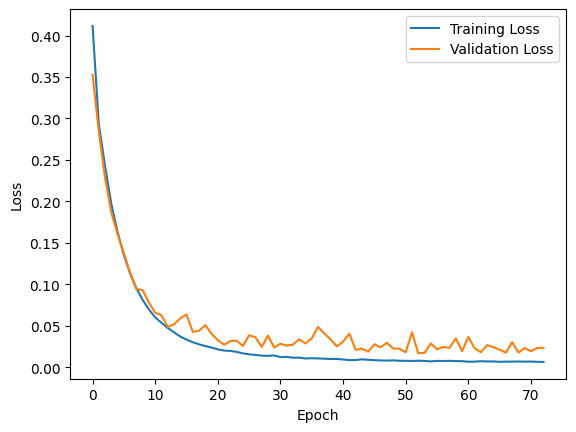

In [17]:
# Plot training and validation loss
plt.plot(history['train_losses'], label='Training Loss')
plt.plot(history['valid_losses'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("loss_plot.png", dpi=300)
plt.show()

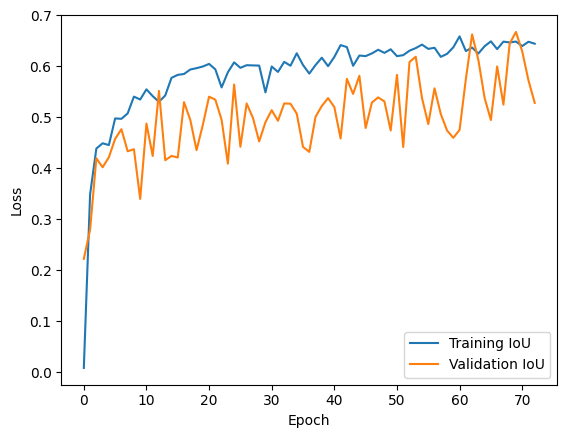

In [18]:
# Plot training and validation loss
plt.plot(history['train_iou'], label='Training IoU')
plt.plot(history['valid_iou'], label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("iou_plot.png", dpi=300)
plt.show()

In [19]:
history['train_iou']

[0.008415380764136634,
 0.34885542059507896,
 0.43890548224641585,
 0.44921723682814696,
 0.4457745233653333,
 0.4979985316437999,
 0.4972243652803691,
 0.507844207089717,
 0.5407972308829074,
 0.5351076209404337,
 0.5551265447627841,
 0.5417288838643727,
 0.5305140456698072,
 0.5430807114586117,
 0.5776516074740042,
 0.5834630687875072,
 0.5852326098389513,
 0.5939855928730777,
 0.5966503581428152,
 0.5998865600646012,
 0.6049979059245643,
 0.59427843647679,
 0.5588617038539075,
 0.5885379739164367,
 0.6080316572677432,
 0.5972822945652985,
 0.6024463730534231,
 0.6020341470954925,
 0.6017089132366218,
 0.5490918910409522,
 0.5999103568083658,
 0.5892761584341996,
 0.6089583882900673,
 0.6014457693484825,
 0.6258370444530578,
 0.6028002059365821,
 0.585983985521662,
 0.6027831187633079,
 0.6172108740553143,
 0.6005761484930835,
 0.6186465116467063,
 0.641858745043672,
 0.6380484193328797,
 0.6013272641681311,
 0.6214200736969475,
 0.6202756742558141,
 0.6256187210871479,
 0.6327706962

# Testing

In [20]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only=True))
model.to(device)

# Validation phase
model.eval()

all_images = []
all_masks = []
all_preds = []

with torch.no_grad():
    for images, masks in tqdm(test_loader):
        images, masks = images.to(device), masks
        masks = masks.int()
        
        # Forward pass
        outputs = model(images)
        images = images.cpu()
        
        probabilities = torch.sigmoid(outputs)
        preds = torch.sigmoid(outputs).round().cpu().detach()
        preds = preds.int()
        
        all_images.extend(images)
        all_masks.extend(masks)
        all_preds.extend(preds)

100%|███████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.96it/s]


In [21]:
print(images.shape, preds.shape, masks.shape)

predictions = torch.Tensor(np.array(all_preds)).view(-1)
gt = torch.Tensor(np.array(all_masks)).view(-1)

torch.Size([16, 1, 128, 128]) torch.Size([16, 1, 128, 128]) torch.Size([16, 1, 128, 128])


In [22]:
predictions.shape

torch.Size([4194304])

In [23]:
dice = dice_loss(gt, predictions).item()
iou = compute_iou(gt, predictions)

print("Dice Loss :", dice)
print("IoU       :", iou)

precison = metrics.precision_score(gt, predictions).item()
recall = metrics.recall_score(gt, predictions).item()
# f1 = metrics.f1_score(gt, predictions).item()

print("Precision :", precison)
print("Recall    :", recall)
# print("F1-Score  :", f1)

Dice Loss : 0.9877347350120544
IoU       : 0.37524086236953735
Precision : 0.6145047576788444
Recall    : 0.49076662597944637


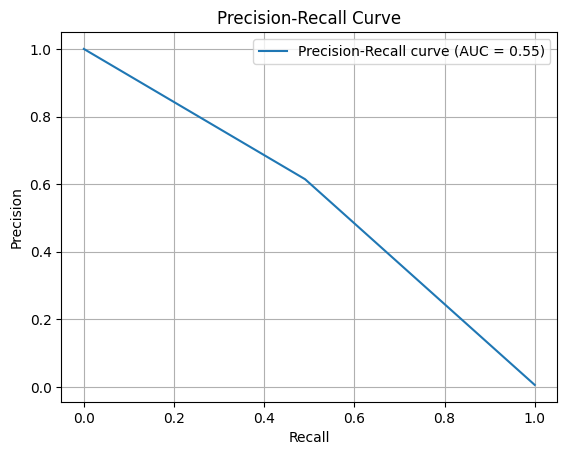

In [24]:
# Calculate precision-recall pairs for different thresholds
precision, recall, thresholds = metrics.precision_recall_curve(gt, predictions)

# Calculate the area under the precision-recall curve (AUC-PR)
auc_pr = metrics.auc(recall, precision)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [25]:
print( metrics.classification_report(gt, predictions) )

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   4168907
         1.0       0.61      0.49      0.55     25397

    accuracy                           1.00   4194304
   macro avg       0.81      0.74      0.77   4194304
weighted avg       0.99      1.00      0.99   4194304



<Figure size 500x380 with 0 Axes>

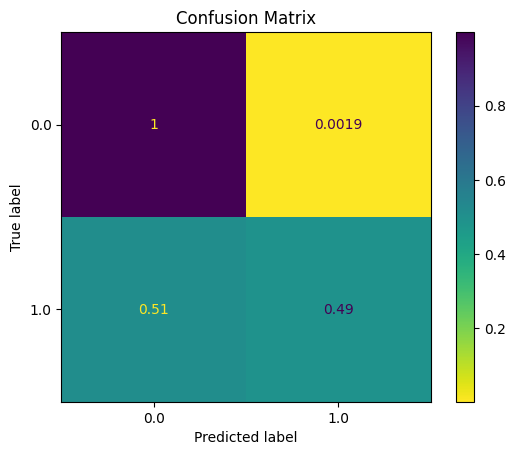

In [26]:
plt.figure(figsize=(5, 3.8))

metrics.ConfusionMatrixDisplay.from_predictions(gt, predictions, normalize='true', cmap='viridis_r')

plt.title("Confusion Matrix")
plt.savefig("cm01.png", dpi=200, bbox_inches='tight')
plt.show()

# Visualization

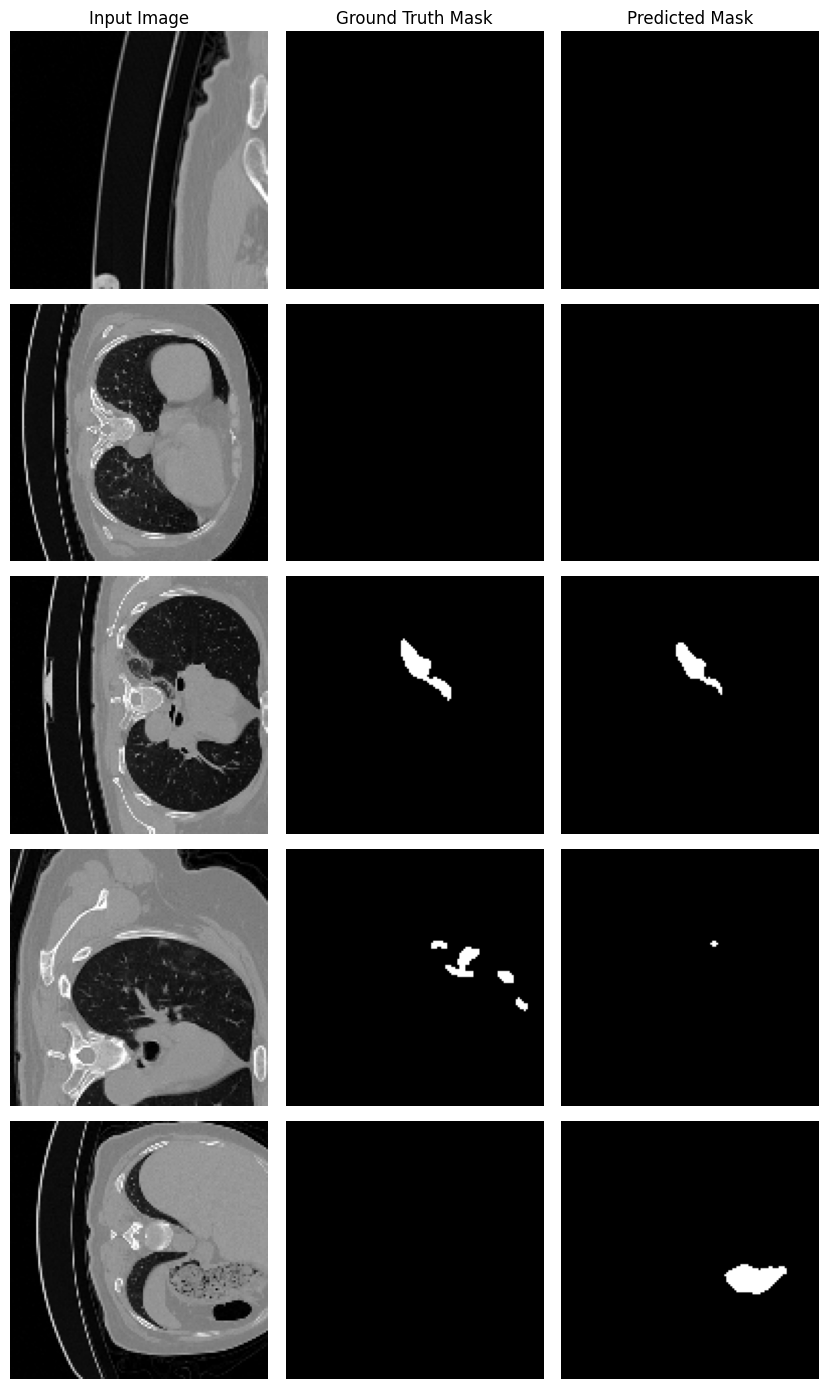

In [27]:
# Move tensors to CPU and detach from the graph to convert them into NumPy arrays
# images_np = images.cpu().numpy()
# masks_np = masks.cpu().numpy()
# preds_np = preds

# Visualize the first example in the batch
fig, ax = plt.subplots(5, 3, figsize=(8.5, 14))

ax[0][0].set_title('Input Image')
ax[0][1].set_title('Ground Truth Mask')
ax[0][2].set_title('Predicted Mask')

for i in range(5):
    # Original input image (first channel, assuming grayscale)
    ax[i][0].imshow(images[i].permute(1,2,0), cmap='gray')
    ax[i][0].axis("off")
    
    # Ground truth mask
    ax[i][1].imshow(masks[i][0], cmap='gray')  # Ground truth mask
    ax[i][1].axis("off")
    
    # Predicted mask
    ax[i][2].imshow(preds[i][0], cmap='gray')  # Predicted mask
    ax[i][2].axis("off")

plt.tight_layout()
plt.savefig("predictions.png", dpi=300)
plt.show()